# Plot alignment statistics of barcode-insert linkage library

## Load libraries and define analysis-specific parameters

In [1]:
suppressMessages(library(Biostrings))
suppressMessages(library(plyranges))
suppressMessages(library(tidyverse))

## Read alignment log

In [2]:
align_log <- list.files("../data/alignments/", pattern = "*.log", full.names = T) %>% 
  enframe("sno", "file") %>% 
  filter(str_detect(file, "stall4control4")) %>% 
  mutate(log = map(file, readLines)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.bowtie2align.log)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  print()

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(log)`”


# A tibble: 42 × 2
   log                                                               sample_name
   <chr>                                                             <chr>      
 1 "199297 reads; of these:"                                         stall4cont…
 2 "  199297 (100.00%) were unpaired; of these:"                     stall4cont…
 3 "    29768 (14.94%) aligned 0 times"                              stall4cont…
 4 "    16433 (8.25%) aligned exactly 1 time"                        stall4cont…
 5 "    153096 (76.82%) aligned >1 times"                            stall4cont…
 6 "85.06% overall alignment rate"                                   stall4cont…
 7 "[bam_sort_core] merging from 0 files and 16 in-memory blocks..." NA         
 8 "199548 reads; of these:"                                         stall4cont…
 9 "  199548 (100.00%) were unpaired; of these:"                     stall4cont…
10 "    28734 (14.40%) aligned 0 times"                              stall4cont…
# … with 

## How many total reads and reads with expected barcodes?


── Column specification ────────────────────────────────────────────────────────
cols(
  sample_name = col_character(),
  type = col_character(),
  count = col_double()
)



# A tibble: 18 × 4
   sample_name              read  type    count
   <chr>                    <chr> <chr>   <dbl>
 1 stall4control4_linkage_1 total all    199297
 2 stall4control4_linkage_1 aln   unique  16433
 3 stall4control4_linkage_1 aln   multi  153096
 4 stall4control4_linkage_2 total all    199548
 5 stall4control4_linkage_2 aln   unique  13748
 6 stall4control4_linkage_2 aln   multi  157066
 7 stall4control4_linkage_3 total all    195212
 8 stall4control4_linkage_3 aln   unique  11100
 9 stall4control4_linkage_3 aln   multi  144480
10 stall4control4_linkage_4 total all    212031
11 stall4control4_linkage_4 aln   unique  14123
12 stall4control4_linkage_4 aln   multi  159188
13 stall4control4_linkage_5 total all    193623
14 stall4control4_linkage_5 aln   unique  11927
15 stall4control4_linkage_5 aln   multi  150841
16 stall4control4_linkage_6 total all    229279
17 stall4control4_linkage_6 aln   unique  16808
18 stall4control4_linkage_6 aln   multi  187489


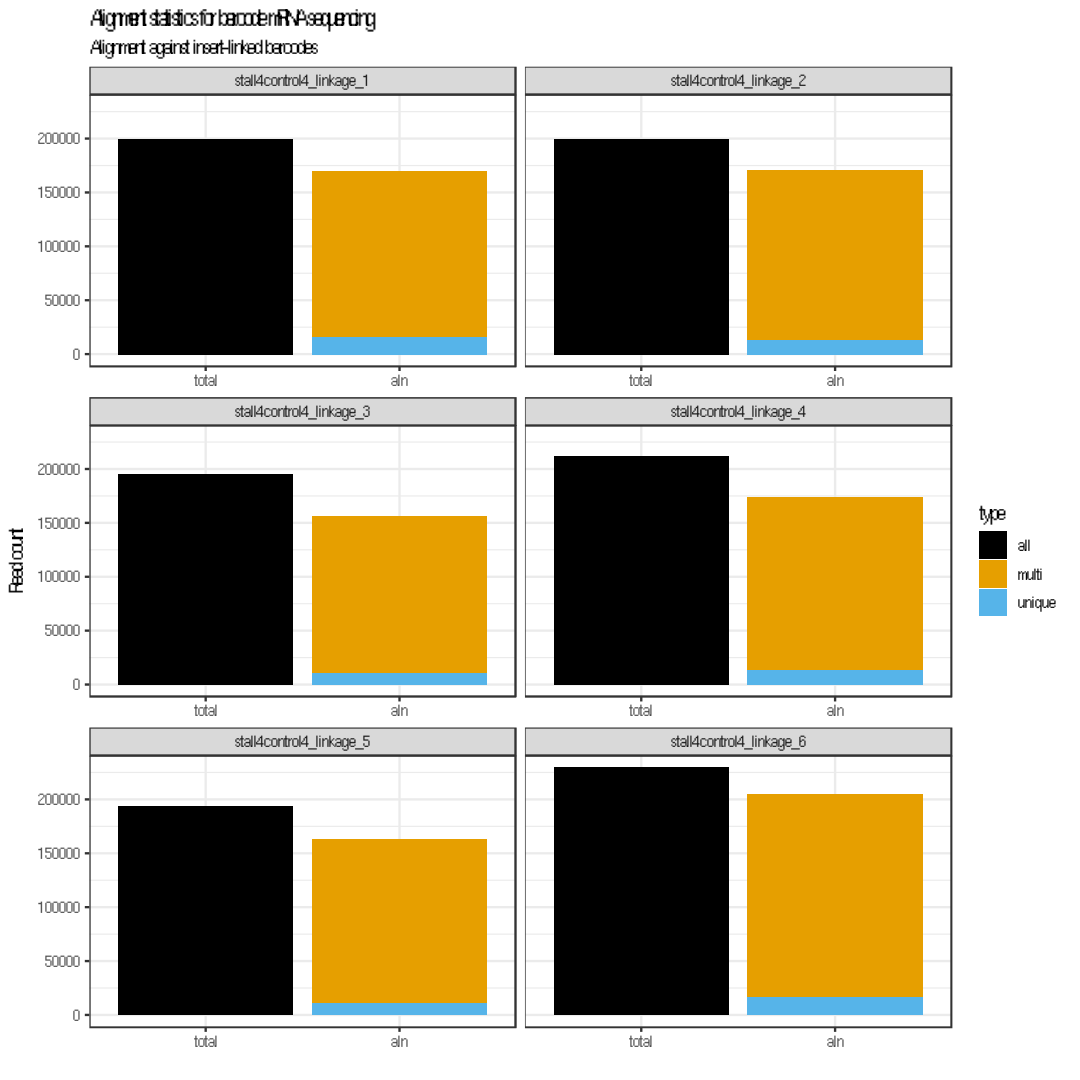

In [8]:
options(repr.plot.width=9, repr.plot.height=9)

plot_data <- align_log %>% 
  mutate(total_all = str_extract(log, "^[:digit:]+(?= reads;)")) %>% 
  mutate(aln_unique = str_extract(log, "[:digit:]+(?=.+exactly)")) %>% 
  mutate(aln_multi = str_extract(log, "[:digit:]+(?=.+>1)")) %>% 
  select(-log) %>% 
  pivot_longer(-sample_name, names_to = 'type', values_to = 'count') %>% 
  filter(!is.na(count)) %>% 
  type_convert() %>% 
  separate(type, c("read", "type")) %>% 
  print()

plot_data %>% 
  ggplot(aes(x = fct_rev(read), y = count, fill = type)) +
  facet_wrap(~sample_name, ncol = 2, scales = "free_x") +
  geom_col() +
  ggthemes::scale_fill_colorblind() +
  theme_bw() +
  labs(x = "", y = "Read count",
       title = "Alignment statistics for barcode mRNA sequencing",
       subtitle = "Alignment against insert-linked barcodes")

## Get insert-barcode linkages with counts

In [4]:
insert_barcode_linkages <- list.files("../data/filtered_barcodes//", 
                                      pattern = ".tsv.gz$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_tsv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.tsv.gz)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  select(-barcode_1) %>%
  print()

Rows: 1800 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): barcode_1
dbl (3): insert_num, barcode_num, read_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1800 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): barcode_1
dbl (3): insert_num, barcode_num, read_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2052 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): barcode_1
dbl (3): insert_num, barcode_num, read_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet 

# A tibble: 12,519 × 4
   insert_num barcode_num read_count sample_name             
        <dbl>       <dbl>      <dbl> <chr>                   
 1          7           1       1592 stall4control4_linkage_1
 2          5           2        902 stall4control4_linkage_1
 3          7           3        590 stall4control4_linkage_1
 4          7           4        588 stall4control4_linkage_1
 5          7           5        525 stall4control4_linkage_1
 6          7           6        521 stall4control4_linkage_1
 7          4           7        480 stall4control4_linkage_1
 8          4           8        479 stall4control4_linkage_1
 9          7           9        475 stall4control4_linkage_1
10          5          10        469 stall4control4_linkage_1
# … with 12,509 more rows


## Get sample annotations


In [5]:

sample_annotations <- read_csv("../annotations/sample_annotations.csv", comment = "#") %>% print()

Rows: 6 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): owner, sample_name, plasmid, library_type, illumina_sample_id, samp...
dbl (6): insert_read, trim5, trim3, barcode1_read, barcode1_start, barcode1_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 6 × 13
  owner sample_name  plasmid libra…¹ illum…² sampl…³ inser…⁴ trim5 trim3 barco…⁵
  <chr> <chr>        <chr>   <chr>   <chr>   <chr>     <dbl> <dbl> <dbl>   <dbl>
1 pb    stall4contr… phphs4… plasmid sample… 146p23        1    50     2       1
2 pb    stall4contr… phphs4… plasmid sample… 146p24        1    50     2       1
3 pb    stall4contr… phphs4… plasmid sample… 146p25        1    50     2       1
4 pb    stall4contr… phphs4… plasmid sample… 146p26        1    50     2       1
5 pb    stall4contr… phphs4… plasmid sample… 146p27        1    50     2       1
6 pb    stall4contr… phphs4… plasmid sample… 146p28        1    50     2       1
# … with 3 more variables: barcode1_start <dbl>, barcode1_length <dbl>,
#   bowtie2_reference <chr>, and abbreviated variable names ¹​library_type,
#   ²​illumina_sample_id, ³​sample_id, ⁴​insert_read, ⁵​barcode1_read


# Plot CDF of the number of reads per barcode

# A tibble: 12,519 × 5
   insert_num barcode_num read_count sample_name              xaxis
        <dbl>       <dbl>      <dbl> <chr>                    <int>
 1          7           1       1592 stall4control4_linkage_1     1
 2          5           2        902 stall4control4_linkage_1     2
 3          5           1        596 stall4control4_linkage_4     1
 4          7           3        590 stall4control4_linkage_1     3
 5          7           4        588 stall4control4_linkage_1     4
 6          7           5        525 stall4control4_linkage_1     5
 7          7           6        521 stall4control4_linkage_1     6
 8          4           7        480 stall4control4_linkage_1     7
 9          4           8        479 stall4control4_linkage_1     8
10          7           9        475 stall4control4_linkage_1     9
# … with 12,509 more rows


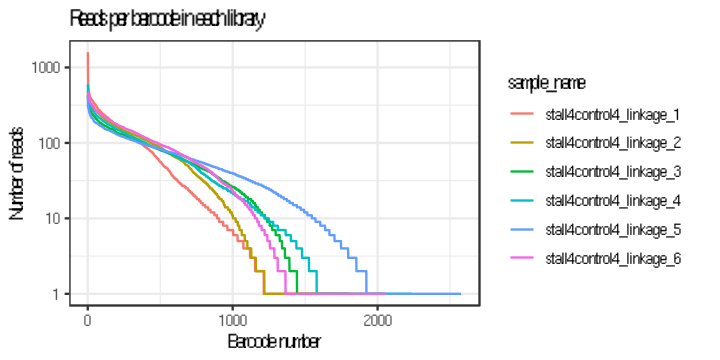

In [6]:
options(repr.plot.width=6, repr.plot.height=3)

plot_data <- insert_barcode_linkages %>% 
  group_by(sample_name) %>% 
  arrange(-read_count) %>% 
  mutate(xaxis = 1:(dplyr::n())) %>% 
  ungroup() %>% 
  print()

plot_data %>% 
  ggplot(aes(x = xaxis, y = read_count, color = sample_name)) +
  geom_line(aes(group = sample_name)) +
  theme_bw() +
  scale_y_log10() +
  labs(x = "Barcode number", y = "Number of reads",
       title = "Reads per barcode in each library") +
  NULL

## Plot CDF of the number of reads per insert, summed over barcodes


`summarise()` has grouped output by 'sample_name'. You can override using the
`.groups` argument.


# A tibble: 42 × 4
   sample_name              insert_num read_count xaxis
   <chr>                         <dbl>      <dbl> <int>
 1 stall4control4_linkage_5          5      30937     1
 2 stall4control4_linkage_2          5      28038     1
 3 stall4control4_linkage_6          2      27640     1
 4 stall4control4_linkage_3          5      27133     1
 5 stall4control4_linkage_6          5      26885     2
 6 stall4control4_linkage_4          5      26156     1
 7 stall4control4_linkage_1          5      24957     1
 8 stall4control4_linkage_1          7      24118     2
 9 stall4control4_linkage_3          2      22381     2
10 stall4control4_linkage_4          7      20900     2
# … with 32 more rows


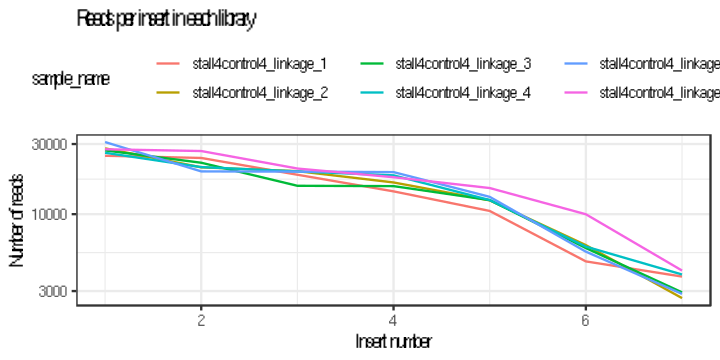

In [7]:
options(repr.plot.width=6, repr.plot.height=3)

plot_data <- insert_barcode_linkages %>% 
  group_by(sample_name, insert_num) %>% 
  summarize(read_count = sum(read_count)) %>% 
  ungroup() %>% 
  group_by(sample_name) %>% 
  arrange(-read_count) %>% 
  mutate(xaxis = 1:(dplyr::n())) %>% 
  ungroup() %>% 
  print()

plot_data %>% 
  ggplot(aes(x = xaxis, y = read_count, color = sample_name)) +
  geom_line(aes(group = sample_name)) +
  theme_bw() +
  theme(legend.position = "top") +
  scale_y_log10() +
  labs(x = "Insert number", y = "Number of reads",
       title = "Reads per insert in each library") +
  NULL